In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import math

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.softmax(self.fc2(x), dim=1)
        return x
    
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        self.actor_net = PolicyNet(state_dim, hidden_dim, action_dim)
        self.actor_optimizer = torch.optim.Adam(self.actor_net.parameters(), lr = actor_lr)
        self.critic_net = ValueNet(state_dim, hidden_dim)
        self.critic_optimizer = torch.optim.Adam(self.critic_net.parameters(), lr = critic_lr)
        self.gamma = gamma
        self.device = device
    
    def take_action(self, state):
        state = torch.tensor([state],dtype=torch.float).to(self.device)
        probs = self.actor_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def update(self, states, actions, rewards, next_states, terminateds):
        states = torch.tensor(states, dtype=torch.float).to(self.device)
        actions = torch.tensor(actions).view(-1,1).to(self.device)
        rewards = torch.tensor(rewards,dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float).to(self.device)
        terminateds = torch.tensor(terminateds, dtype=torch.float).view(-1,1).to(self.device)
        
        vs = self.critic_net(states)
        vs_prime = self.critic_net(next_states)
        td_target = rewards + self.gamma * vs_prime *(1 - terminateds)
        td_delta = td_target - vs

        log_probs = torch.log(self.actor_net(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        #critic_loss = torch.pow(td_delta, 2).mean()#
        #critic_loss = torch.nn.functional.mse_loss(self.critic_net(states), td_target.detach(), reduction="mean")
        critic_loss = torch.nn.functional.mse_loss(vs, td_target.detach(), reduction="mean")
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()




actor_lr = 1e-3
critic_lr = 1e-2

hidden_dim = 128
gamma = 0.98
device = torch.device("cpu") #torch.device("cuda") if torch.cuda.is_available () else torch.device("cpu")
env_name = "CartPole-v0"

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
env.close()

def reset_seed():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)

def train(agent, num_episodes):
    reset_seed()
    reward_stat = np.zeros(num_episodes)
    env = gym.make(env_name)
    for episode in range(num_episodes):
        state, info = env.reset(seed=0)
        total_reward = 0
        states=[]
        actions=[]
        rewards=[]
        next_states=[]
        terminateds=[]
        while True:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            terminateds.append(terminated)
            state = next_state
            total_reward += reward
            if terminated or truncated:
                break
        agent.update(states, actions, rewards, next_states, terminateds)
        if episode*10 % num_episodes == 0:
            print("episode:", episode, "total_reward:",total_reward)
        reward_stat[episode] = total_reward
    env.close()
    return reward_stat

def test(agent, num_episodes):
    env = gym.make(env_name,render_mode="human")
    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0
        while True:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            state = next_state
            total_reward += reward
            if terminated or truncated:
                break
        #print("episode:", episode, "total_reward:",total_reward)
    env.close()


def moving_average(nums, n):
    beta = 1 - 1.0/n
    alpha = 1.0 - beta
    avg = nums[0]
    res = np.zeros_like(nums)
    for n in range(len(nums)):
        avg = avg * beta + nums[n]*alpha
        res[n] = avg
    return res        


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 0 total_reward: 25.0
episode: 80 total_reward: 56.0
episode: 160 total_reward: 14.0
episode: 240 total_reward: 79.0
episode: 320 total_reward: 60.0
episode: 400 total_reward: 200.0
episode: 480 total_reward: 200.0
episode: 560 total_reward: 200.0
episode: 640 total_reward: 200.0
episode: 720 total_reward: 200.0


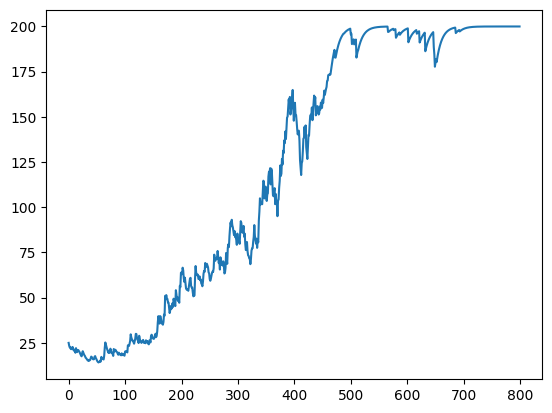

In [20]:
num_episodes = 800
reset_seed()
agent1 = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)
reward_stat1  = train(agent1, num_episodes)
plt.plot(range(len(reward_stat1)), moving_average(reward_stat1,10))
plt.show()
